# import packages

In [8]:
from __future__ import print_function
import pandas as pd
import numpy as np
import glob
import re
import os
import sys
import astroscrappy
from astropy.io import fits
#sys.path.remove('/Users/gks/Dropbox/mypylib')
import astropy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
from matplotlib.colors import to_rgb as rgb
import astropy.io.fits 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import aperture_photometry
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture, CircularAnnulus
from sklearn.metrics.pairwise import euclidean_distances





In [9]:
sys.path.append('src/')
import filepath
import utils
filepath, utils

(<module 'filepath' from 'src\\filepath.py'>,
 <module 'utils' from 'src\\utils.py'>)

In [10]:
class FitsImage(object):
    """
    A helper class when reading fits files. Depends on pyFits.
    """
    DIRLOC = ''
    def __init__(self,filename=None,data=None,header=None,imgnumber=0):
        if filename!=None:
            self.filename = filename
            self.hdulist = fits.open(self.filename)
            self.header = self.hdulist[imgnumber].header
            data = self.hdulist[imgnumber].data
            self.data = data.astype(float)
        else:
            self.filename = ""
            self.hdulist = None
            self.header = header
            self.data = data
    
    def remove_cosmics(self,
                       verbose=True,
                       fsmode='convolve',
                       save_cleaned=False,
                       savefolder=None,
                       save_suffix="_cleaned",
                       overwrite=False,
                       gain=1.,
                       psffwhm=16.,
                       psfsize=16,
                       sigclip=6.,
                       sigfrac=0.3,
                       objlim=5.,
                       psfmodel="gauss",
                       pssl=0.,
                       cleantype="medmask",
                       **cosmics_kwargs):
        """
        Remove cosmic rays with astroscrappy
        
        Main thing is to study how the results change with the different settings.
        
        Main parameters are: GAIN and psffwhm
        """
        if verbose: print("Cleaning cosmic rays")
        self.cosmics_mask, self.cosmics_cleaned_data = astroscrappy.detect_cosmics(self.data,
                                                                                   objlim=objlim,
                                                                                   sigfrac=sigfrac,
                                                                                   sigclip=sigclip,
                                                                                   psfsize=psfsize,
                                                                                   verbose=verbose,
                                                                                   gain=gain,
                                                                                   psffwhm=psffwhm,
                                                                                   fsmode=fsmode,
                                                                                   psfmodel=psfmodel,
                                                                                   pssl=pssl,
                                                                                   cleantype=cleantype,
                                                                                   **cosmics_kwargs)
        if save_cleaned:
            # Saving file
            fp = filepath.FilePath(self.filename)
            make_dir(savefolder)
            if savefolder is not None: 
                fp.directory = savefolder
            fp.add_suffix(save_suffix)
            self.cosmics_save_filename = fp._fullpath
            self.savefits(filename=self.cosmics_save_filename,
                          data=self.cosmics_cleaned_data.astype(np.int32),
                          verbose=verbose,
                          overwrite=overwrite)
    
    def savefits(self,data=None,filename="",suffix="",verbose=True,overwrite=True):
        if data is None:
            data = self.data
        if filename=="":
            fp = filepath.Filepath(self.filename)
            if suffix=="":
                suffix = "_out"
            fp.add_suffix(suffix)
            filename=fp._fullpath
        self.header["BITPIX"]=16
        self.header["BSCALE"]=1
        self.header["BZERO"]=32768
        fits.writeto(filename,
                     data=data,
                     header=self.header,
                     overwrite=overwrite,
                     output_verify="warn")
        if verbose: print("Saved to",filename)
            
def make_dir(dirname,verbose=True):
    """    Make a directory    """
    try:
        os.makedirs(dirname)
        if verbose==True: print("Created folder:",dirname)
    except OSError:
        if verbose==True: print(dirname,"already exists. Skipping")

# Find all of the files to clean

In [217]:
FOLDERNAME = os.path.abspath(r'''C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210422_TIC-207x\Q2UW01\UT210423''')
regex = "*45.041*.fits"
files = glob.glob(os.path.join(FOLDERNAME,regex))

In [218]:
files

['C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210422_TIC-207x\\Q2UW01\\UT210423\\tic207-diffuser-semrock-45.0410.fits',
 'C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210422_TIC-207x\\Q2UW01\\UT210423\\tic207-diffuser-semrock-45.0411.fits',
 'C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210422_TIC-207x\\Q2UW01\\UT210423\\tic207-diffuser-semrock-45.0412.fits',
 'C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210422_TIC-207x\\Q2UW01\\UT210423\\tic207-diffuser-semrock-45.0413.fits',
 'C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210422_TIC-207x\\Q2UW01\\UT210423\\tic207-diffuser-semrock-45.0414.fits',
 'C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210422_TIC-207x\\Q2UW01\\UT210423\\tic207-diffuser-semrock-45.0415.fits',
 'C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210422_TIC-207x\\Q2UW01\\UT210423\\tic207-diffuser-semrock-45.0416.fits']

# Loop through all test files and clean

- This saves the files in a 0_CLEANED subdirectory in the FOLDERNAME
- appends a *_cleaned* to the filenames

In [219]:
psffwhms = [10]
psfsizes = [10]


#rows = ['{}'.format(row) for row in ['Target', 'Reference']]
cols = ['{}'.format(col) for col in ['Cleaned', 'Removed']]

for k in psffwhms:
    for j in psfsizes:
        print("k ="+str(k))
        print("j ="+str(j))
        for i, f in enumerate(files):
            print(i,f)
            fimg = FitsImage(f)
            data_uncleaned=np.copy(fimg.data)
            fimg.remove_cosmics(save_cleaned=True,
                                    gain=1, #gain needs to be changed in 4 locations for filenames
                                    sepmed=True,
                                    overwrite=True,
                                    psffwhm=k,
                                    psfsize=j,
                                    save_suffix='_delta_cleaned_gain_1_sepmed_T_psffwhm_'+str(k)+'_psfsize_'+str(j),
                                    savefolder=os.path.join(FOLDERNAME,'0_CLEANED_SYSTEMATIC_TESTS/'))
            data_cleaned = fimg.cosmics_cleaned_data
            data_delta = data_uncleaned-data_cleaned
            
            #Calculate the mean, median, std of the cleaned data set

            mean, median, std = sigma_clipped_stats(data_cleaned)
            print((mean, median, std))

            #Calculate the mean, median, std of the delta data set

            mean_delta, median_delta, std_delta = sigma_clipped_stats(data_delta)
            print((mean_delta, median_delta, std_delta))

            #Create a mask for the cross hair shape on ARCTIC 
            mask = np.zeros(data_cleaned.shape, dtype=bool)
            mask[500:530,0:2000] = True
            mask[0:2000,510:540] = True
            #Subtract the background and use DAOStarFinder to find the stars in the cleaned image

            daofind = DAOStarFinder(fwhm=10, threshold=5.*std)          
            sources = daofind(data_cleaned - median, mask=mask)
            #for col in sources.colnames:
                #sources[col].info.format = '%.8g'
            #print('There are '+str(len(sources)) + ' stars detected in this FOV.')
            #print(sources)  
            #positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
            #apertures = CircularAperture(positions, r=22.)
            annulus_aperture = CircularAnnulus(positions, r_in=40, r_out=60)

            #Subtract the background and use DAOStarFinder to find the charged particles from astroscrappy to show the removed points in the image

            daofind_CR = DAOStarFinder(fwhm=1.15, threshold=5.*std_delta)          
            sources_CR = daofind_CR(data_delta - median_delta, mask=mask)
            #for col in sources_CR.colnames:
                #sources_CR[col].info.format = '%.8g'
            #print('There are '+str(len(sources_CR)) + ' charged particles detected in this FOV.') 
            #positions_CR = np.transpose((sources_CR['xcentroid'], sources_CR['ycentroid']))
            #apertures_CR = CircularAperture(positions_CR, r=5.)

            #Plot the FOV with photometric aperture and CR/charged particles marked

            norm = ImageNormalize(stretch=SqrtStretch())
            fig, ax = plt.subplots(ncols=1,nrows=1)
            plt.imshow(data_cleaned, cmap='viridis', origin='lower', norm=norm, interpolation='nearest')
            apertures.plot(color='white', lw=1.5, alpha=0.5, label='Photometric Aperture') 
            apertures_CR.plot(color='red', lw=1.5, alpha=0.5, label='Charged Particle')  
            annulus_aperture.plot(color='blue', lw=1.5, alpha=0.5, label='Background Annulus')
            plt.title('20210331, TIC-207x, ARCTIC')
            plt.xlabel('Pixels')
            plt.ylabel('Pixels')
            white_patch =mpatches.Patch(color='white', label = 'Photometric Aperture')
            blue_patch =mpatches.Patch(color='blue', label = 'Background Annulus')
            red_patch =mpatches.Patch(color='red', label = 'Charged Particle')
            plt.legend(handles=[white_patch, blue_patch, red_patch]) 
            fig.suptitle('File:'+ str(''.join(re.findall("-diffuser-semrock-45.(\d+).fits",files[i])))+', PSFFWHM='+str(k)+', PSFSIZE='+str(j) + ', gain=1') #MUST CHANGE THE REGEX OF FILENAME IF YOU WANT IT LABELLED CORRECTLY
            #fig.savefig(r'''C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210422_TIC-207x\Q2UW01\UT210423\0_CLEANED_SYSTEMATIC_TESTS\UT20210422_cleaned_gain_1_sepmed_T_psffwhm_'''+str(k)+'_psfsize_'+str(j)+'_multiplot_'+str(''.join(re.findall("-diffuser-semrock-45.(\d+).fits",files[i])))+'.png',dpi=200) #MUST CHANGE THE REGEX OF FILENAME IF YOU WANT IT SAVED CORRECTLY
            plt.close(fig)


            #plot the cleaned and delta for target star
            fig, axx = plt.subplots(ncols=2,nrows=1)
            for ax, col in zip(axx, cols):
                ax.set_xlabel(col, rotation=0, size='large')
            axx.flatten()[0].imshow(data_cleaned[310:390,340:420])
            axx.flatten()[1].imshow(data_delta[310:390,340:420])
            #axx.flatten()[2].imshow(data_cleaned[0:2000,0:2000])
            #axx.flatten()[3].imshow(data_delta[0:2000,0:2000])
            fig.suptitle('File:'+ str(''.join(re.findall("-diffuser-semrock-45.(\d+).fits",files[i])))+', PSFFWHM='+str(k)+', PSFSIZE='+str(j) + ', gain=1') #MUST CHANGE THE REGEX OF FILENAME IF YOU WANT IT LABELLED CORRECTLY
            fig.savefig(r'''C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210422_TIC-207x\Q2UW01\UT210423\0_CLEANED_SYSTEMATIC_TESTS\UT20210331_cleaned_gain_1_sepmed_T_psffwhm_'''+str(k)+'_psfsize_'+str(j)+'_'+str(''.join(re.findall("-diffuser-semrock-45.(\d+).fits",files[i])))+'.png',dpi=200) #MUST CHANGE THE REGEX OF FILENAME IF YOU WANT IT SAVED CORRECTLY
            plt.close(fig)
            
            
                      

k =10
j =10
0 C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210422_TIC-207x\Q2UW01\UT210423\tic207-diffuser-semrock-45.0410.fits
Cleaning cosmic rays
Starting 4 L.A.Cosmic iterations
Iteration 1:
<ipython-input-10-7b2efe561d8e>:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.cosmics_mask, self.cosmics_cleaned_data = astroscrappy.detect_cosmics(self.data,
1412 cosmic pixels this iteration
Iteration 2:
120 cosmic pixels this iteration
Iteration 3:
119 cosmic pixels this iteration
Iteration 4:
126 cosmic pixels this iteration
C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210422_TIC-207x\Q2UW01\UT210423\0_CLEANED_SYSTEMATIC_TESTS/ already exists. Skipp

In [29]:
#Find cleaned files

FOLDERNAME2 = os.path.abspath(r'''C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210331_TIC-207x\CR_TEST\0_CLEANED_SYSTEMATIC_TESTS''')
regex = "*0188.fits"
files2 = glob.glob(os.path.join(FOLDERNAME2,regex))

C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210331_TIC-207x\CR_TEST\0_CLEANED_SYSTEMATIC_TESTS\TIC-207-diffuser-i.0177_delta_cleaned_gain_1_sepmed_T_psffwhm_2_psfsize_2.fits
384.1920081711377 349.2391829623439
[[ 84.30498905 278.81628058]
 [377.54627629 332.62382313]
 [110.00722174 389.00806027]
 [412.92097431 679.50697538]
 [986.38261006 826.67940595]
 [839.743936   872.89939325]
 [353.11073066 974.36575875]
 [384.19200817 349.23918296]]
[[   0.          298.13705603  113.14960485  518.20989828 1055.4136812
   961.0529368   745.68465406  308.04481722]
 [ 298.13705603    0.          273.41603448  348.68222004  784.07435886
   711.00236871  642.20698206   17.89513717]
 [ 113.14960485  273.41603448    0.          419.6979404   979.58666185
   875.59493733  633.83195818  277.05389496]
 [ 518.20989828  348.68222004  419.6979404     0.          592.0455827
   468.59200582  300.86370231  331.51495925]
 [1055.4136812   784.07435886  979.58666185  592.0455827     0.
   153.75040798  65

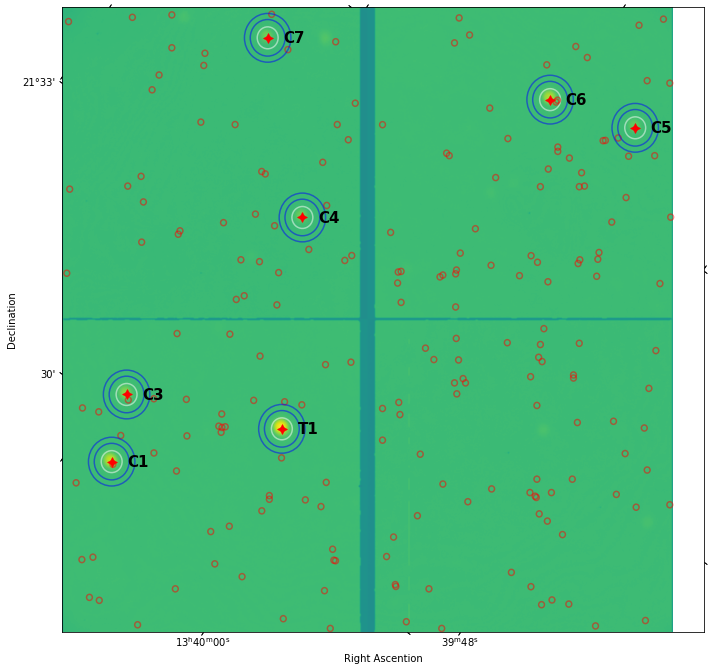

residual_aperture_sum
---------------------
              1249820
            2403992.8
            534498.91
            358086.31
            260685.87
            928626.86
            328853.21
 id  xcenter   ycenter  ...  aper_bkg aper_sum_bkgsub aperture_sum
       pix       pix    ...                                       
--- --------- --------- ... --------- --------------- ------------
  1 84.304989 278.81628 ... 1356828.7       1356828.7    1356828.7
  2 377.54628 332.62382 ... 1358864.5       1358864.5    1358864.5
  3 110.00722 389.00806 ... 1355810.9       1355810.9    1355810.9
  4 412.92097 679.50698 ... 1305934.9       1305934.9    1305934.9
  5 986.38261 826.67941 ...   1338507         1338507      1338507
  6 839.74394 872.89939 ... 1351739.4       1351739.4    1351739.4
  7 353.11073 974.36576 ... 1320185.2       1320185.2    1320185.2
 id xcentroid ycentroid sharpness  ...    flux       mag     aper_sum_bkgsub_T1
--- --------- --------- ---------- ... --------- ---

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210331_TIC-207x\\CR_TEST\\0_CLEANED_SYSTEMATIC_TESTS/measurements_TIC_207x_ARCTIC.csv'

In [84]:
#Make plot based on caleb's code

ra=205.011752
dec=21.520995

for a in files2:
    print(a)
    hdul = fits.open(a)
    wcsfunc = WCS(hdul[0].header)
    img = hdul[0].data

    ncol = 1
    nrow = 1
    fig = plt.figure(figsize=(11.5, 11.5))
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), projection=wcsfunc)
    ax1.imshow(img, interpolation='bicubic', cmap='viridis', aspect='auto', zorder=0, norm=LogNorm())
    ax1.set_ylabel("Declination")
    ax1.set_xlabel("Right Ascention")
    #ax1.set_xlim((0,3000))

    xpix = sources['xcentroid']
    #print(xpix)
    ypix = sources['ycentroid']


    #minimize eucliean distance, which point is closest to target
    x_target, y_target = wcsfunc.all_world2pix(ra, dec, 0)
    print(x_target, y_target)

    points = np.vstack([np.hstack([xpix,x_target]),np.hstack([ypix,y_target])]).T
    separation = euclidean_distances(points)

    #import pdb ; pdb.set_trace()
    print(points)
    print(separation)
    target_index = np.argsort(separation[-1])[1]
    closest_indexes = np.
    print(target_index)

    
    ax1.scatter(xpix, ypix, marker=(4,1), color='red', s=100, alpha=1.0, lw=0.5, zorder=5, label='Pixel Coordinate')
    #plt.legend(loc='upper left', fontsize=22, frameon=True)
    xoffset = [45]
    for i in range(0,len(sources)):
        #print(i)
        ref_stars = np.arange(1, len(sources)+1)
        #print(ref_stars[i])
        if i != target_index:
            ax1.text(xpix[i]+xoffset, ypix[i], 'C{}'.format(ref_stars[i]), horizontalalignment='center', verticalalignment='center', fontdict={'size':15,'weight':'bold'})
            phot_table.append()
        else:
            ax1.text(xpix[i]+xoffset, ypix[i], 'T1', horizontalalignment='center', verticalalignment='center', fontdict={'size':15,'weight':'bold'})
    apertures = CircularAperture(positions, r=18.)
    annulus_aperture = CircularAnnulus(positions, r_in=30, r_out=40)
    apertures_CR = CircularAperture(positions_CR, r=5.)
    apertures.plot(color='white', lw=1.5, alpha=0.5, label='Photometric Aperture') 
    apertures_CR.plot(color='red', lw=1.5, alpha=0.5, label='Charged Particle')  
    annulus_aperture.plot(color='blue', lw=1.5, alpha=0.5, label='Background Annulus')
    for m in range(0,len(files2)):
        #print(m)
        plt.savefig(FOLDERNAME2+'\pixelcoordinate_plot_'+str(''.join(re.findall("-diffuser-i.(\d+)",files2[m])))+'.png',dpi=200, bbox_inches='tight')
    plt.show()


    # We perform photometry in both apertures. The aperture_sum_0 column refers to the first aperture (the circular aperture) in the list of inpit apertures and aperture_sum_1 column refers to the second aperture (the circular annulus)

    #To calculate the mean local background within the      circular annulus aperture, we need to divide its       sum by its area. The mean value can be calculated       by using the area() attribute:

    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area

    #The total background within the circular aperture is then the mean local background times the circular aperture area:

    bkg_sum = bkg_mean * apertures.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'
    print(phot_table['residual_aperture_sum'])

    #We can use aperture masks to directly access the pixel values in any aperture. Let's do that for the annulus aperture. 

    annulus_masks = annulus_aperture.to_mask(method='center')

    #Let's calculate the sigma-clipped median to estimate the background level
    

    #Do this for all source sin the image by using sigma clipped median of all the pixels in the background annuli for background estimates in each source

    bkg_median = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(img)
        annulus_data_1d = annulus_data[mask.data > 0]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)
    bkg_median = np.array(bkg_median)
    # create Table to calculated aperture_sum
    apers = [apertures, annulus_aperture]
    phot_table = aperture_photometry(img, apers, wcs=wcsfunc)
    phot_table['annulus_median'] = bkg_median
    phot_table['aper_bkg'] = bkg_median * apertures.area
    phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum'] = phot_table['aper_bkg']
    sources['aper_sum_bkgsub_T1'] = phot_table['aper_sum_bkgsub']
    
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    
    #phot_table['sources'] = sources
    print(phot_table)
    print(sources)

    #make a csv
    df = pd.DataFrame(phot_table['aper_sum_bkgsub'].data, columns=['Flux_T1'])
    df_T = df.transpose()
    df_T.to_csv(FOLDERNAME2 +'/measurements_TIC_207x_ARCTIC.csv', sep=',')
    


In [94]:
arr = separation[-1]
print(arr)
k = 7
ind = np.argpartition(arr, k)[:k]
arr[ind]
ind

[308.04481722  17.89513717 277.05389496 331.51495925 768.49377846
 694.08038064 625.89877901   0.        ]


array([0, 1, 2, 3, 7, 5, 6], dtype=int64)

In [14]:
#Create master combined bias image

from pathlib import Path
from astropy.stats import mad_std
from astropy import units as u
import ccdproc as ccdp
from astropy.nddata import CCDData

FOLDERNAME3 = os.path.abspath(r'''C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210331_TIC-207x\0_bias''')
regex = "*.fits"
files3 = glob.glob(os.path.join(FOLDERNAME3,regex))


bias_files = ccdp.ImageFileCollection(Path(FOLDERNAME3), keywords = ['filename'.upper(), 'imagetyp'.upper(), 'filter'.upper(), 'exptime'.upper(), 'naxis1'.upper(), 'naxis2'.upper()])
bias_files.summary['filename'.upper(), 'imagetyp'.upper(), 'filter'.upper(), 'exptime'.upper(), 'naxis1'.upper(), 'naxis2'.upper()]


VerifyError: Unparsable card (CD1_1), fix it first with .verify('fix').

In [39]:
hdul = fits.open(files3)
wcsfunc = WCS(hdul[0].header)
img = hdul[0].data
data = CCDData(img, unit=u.adu)
combined_biases = ccdp.combine(data, method='average', sigma_clip=True, sigma_clip_low_threshold=5, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, mem_limit=350e6)

OSError: File-like object does not have a 'write' method, required for mode 'ostream'.

In [32]:
phot_table['aper_sum_bkgsub'].data

array([3159487.16534464, 2595583.85039589, 3077039.20774383,
       2486671.11628124, 2642915.08531487, 2664799.41973978,
       2610851.99069233])